Загрузка данных

In [19]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 64
# convert data to torch.FloatTensor
transform = transforms.ToTensor()
# get the training datasets
train_data = datasets.MNIST(root='data', train=True,
 download=True, transform=transform)
# prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
 num_workers=num_workers)



Визуализация

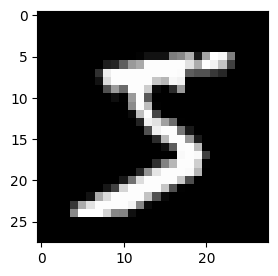

In [20]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()
# get one image from the batch
img = np.squeeze(images[0])
fig = plt.figure(figsize = (3,3))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

Дискриминатор

In [21]:
import torch.nn as nn
import torch.nn.functional as F
class Discriminator(nn.Module):
  def __init__(self, input_size=784, hidden_dim=128, output_size=1):
    super(Discriminator, self).__init__()
    self.input_size=input_size
    # TO DO: define all layers
    # define hidden linear layers (2-3)

    self.fc1=nn.Linear(input_size, hidden_dim)
    self.fc2=nn.Linear(hidden_dim, hidden_dim//2)

    # final fully-connected layer
    self.fc3 =nn.Linear(hidden_dim//2, output_size)
    self.relu=nn.LeakyReLU()

    # dropout layer
    self.dropout=nn.Dropout(0.3)

  def forward(self, x):
    #TO DO: make forward
    # flatten image
    x=x.view(-1, self.input_size)
    # pass x through all layers
    # apply leaky relu activation to all hidden layers
    # dropout
    x=self.fc1(x)
    x=self.relu(x)
    x=self.dropout(x)
    x=self.fc2(x)
    x=self.relu(x)
    x=self.dropout(x)
    x=self.fc3(x)

    # final output
    return x


Генератор

In [22]:
class Generator(nn.Module):
   def __init__(self, input_size, hidden_dim, output_size):
    super(Generator, self).__init__()

    # TODO: define all layers
    # define hidden linear layers (2-3)

    self.fc1=nn.Linear(input_size, hidden_dim)
    self.fc2=nn.Linear(hidden_dim, hidden_dim//2)

    # final fully-connected layer

    self.fc3 =nn.Linear(hidden_dim//2, output_size)
    self.relu=nn.LeakyReLU()

    # dropout layer
    self.dropout=nn.Dropout(0.3)
    self.tanh=nn.Tanh()

   def forward(self, x):
    # pass x through all layers
    x=self.fc1(x)
    x=self.relu(x)
    x=self.dropout(x)
    x=self.fc2(x)
    x=self.relu(x)
    x=self.dropout(x)
    x=self.fc3(x)

    # final layer should have tanh applied

    x=self.tanh(x)

    return x

Настройка гиперпараметров

In [23]:
# Discriminator hyperparams
# Size of input image to discriminator (28*28)
input_size =784
# Size of discriminator output (real or fake)
d_output_size =1
# Size of *last* hidden layer in the discriminator
d_hidden_size =128

# Generator hyperparams
# Size of latent vector to give to generator
z_size =100
# Size of generator output (generated image)
g_output_size =784
# Size of *first* hidden layer in the generator
g_hidden_size =128


Построение сети

In [24]:
# instantiate discriminator and generator
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)
# check that they are as you expect
print(D)
print()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=784, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.3, inplace=False)
  (tanh): Tanh()
)


Ошибки генератора и дискриминатора

In [25]:
# TO DO: Calculate losses
def real_loss(D_out, smooth=False):
 # compare logits to real labels
 # smooth labels if smooth=True
 batch_size = D_out.size(0)
 # label smoothing
 if smooth:
  # smooth, real labels = 0.9
  labels = torch.ones(batch_size) * 0.9 # Сглаженные метки = 0.9
 else:
  labels = torch.ones(batch_size) #истинные метки 1


 # numerically stable loss
 criterion = torch.nn.BCEWithLogitsLoss()

 # calculate loss
 loss = criterion(D_out, labels)
 return loss

def fake_loss(D_out):
 # compare logits to fake labels
 batch_size = D_out.size(0)

 labels = torch.zeros(batch_size) # fake labels = 0

 criterion = torch.nn.BCEWithLogitsLoss()

 # calculate loss
 loss = criterion(D_out, labels)
 return loss


Оптимизатор

In [26]:
import torch.optim as optim
# learning rate for optimizers
lr = 0.002
# TO DO: Create optimizers for the discriminator and generator
# Use Adam
d_optimizer = optim.Adam(D.parameters(), lr=lr)
g_optimizer =optim.Adam(G.parameters(),lr=lr)

Обучение

In [27]:
import pickle as pkl

# training hyperparams
num_epochs = 50

# keep track of loss and generated, "fake" samples
samples = []
losses = []
print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance

sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network

D.train()
G.train()

for epoch in range(num_epochs):

  for batch_i, (real_images, _) in enumerate(train_loader):

      batch_size = real_images.size(0)

      ## Important rescaling step ##
      real_images = real_images*2 - 1 # rescale input images from [0,1) to [-1, 1)

      # ============================================
      # TO DO: TRAIN THE DISCRIMINATOR
      # ============================================
      d_optimizer.zero_grad()

      # 1. Train with real images
      # Compute the discriminator losses on real images
      # smooth the real labels

      D_real= D(real_images).squeeze(1)

      d_real_loss = real_loss(D_real, smooth=True)

      # 2. Train with fake images

      # Generate fake images
      z = np.random.uniform(-1, 1, size=(batch_size, z_size))
      z = torch.from_numpy(z).float()
      fake_images = G(z)

      # Compute the discriminator losses on fake images
      D_fake = D(fake_images.detach()).squeeze(1)
      d_fake_loss = fake_loss(D_fake)

      # add up loss and perform backprop
      d_loss = d_real_loss + d_fake_loss
      d_loss.backward()
      d_optimizer.step()

      # =========================================
      # TO DO: TRAIN THE GENERATOR
      # =========================================

      g_optimizer.zero_grad()

      # 1. Train with fake images and flipped labels

      # Generate fake images
      z = np.random.uniform(-1, 1, size=(batch_size, z_size))
      z = torch.from_numpy(z).float()
      fake_images = G(z)

      # Compute the discriminator losses on fake images
      # using flipped labels!
      D_fake = D(fake_images).squeeze(1)
      g_loss = real_loss(D_fake)# use real loss to flip labels

      # perform backprop
      g_loss.backward()
      g_optimizer.step()


      # Print some loss stats
      if batch_i % print_every == 0:
          # print discriminator and generator loss
          print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(epoch+1, num_epochs, d_loss.item(), g_loss.item()))
  ## AFTER EACH EPOCH##
  # append discriminator loss and generator loss
  losses.append((d_loss.item(), g_loss.item()))

  # generate and save sample, fake images
  G.eval() # eval mode for generating samples
  samples_z = G(fixed_z)
  samples.append(samples_z)
  G.train() # back to train mode
# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
 pkl.dump(samples, f)


Epoch [    1/   50] | d_loss: 1.3561 | g_loss: 0.6375
Epoch [    1/   50] | d_loss: 0.4228 | g_loss: 3.4955
Epoch [    1/   50] | d_loss: 0.5705 | g_loss: 3.2950
Epoch [    2/   50] | d_loss: 0.9043 | g_loss: 2.7286
Epoch [    2/   50] | d_loss: 1.1277 | g_loss: 1.3993
Epoch [    2/   50] | d_loss: 0.8860 | g_loss: 1.8969
Epoch [    3/   50] | d_loss: 0.8323 | g_loss: 2.4873
Epoch [    3/   50] | d_loss: 0.9667 | g_loss: 1.9526
Epoch [    3/   50] | d_loss: 1.1129 | g_loss: 1.2246
Epoch [    4/   50] | d_loss: 1.2189 | g_loss: 1.2893
Epoch [    4/   50] | d_loss: 1.1586 | g_loss: 1.1114
Epoch [    4/   50] | d_loss: 1.0806 | g_loss: 1.2593
Epoch [    5/   50] | d_loss: 1.1574 | g_loss: 1.1681
Epoch [    5/   50] | d_loss: 1.2045 | g_loss: 1.1747
Epoch [    5/   50] | d_loss: 1.0827 | g_loss: 0.9931
Epoch [    6/   50] | d_loss: 1.1934 | g_loss: 1.3428
Epoch [    6/   50] | d_loss: 1.1367 | g_loss: 1.4627
Epoch [    6/   50] | d_loss: 1.2417 | g_loss: 0.9331
Epoch [    7/   50] | d_loss

Визуализация ошибок

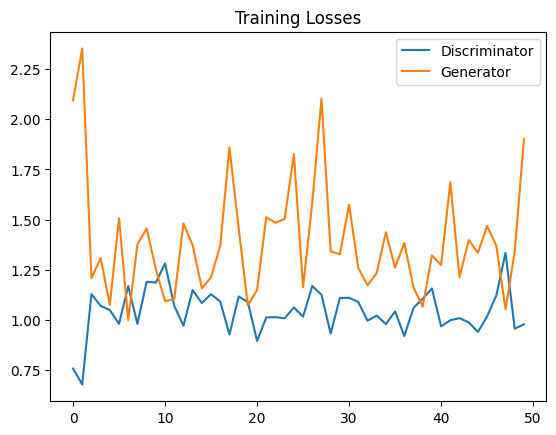

In [28]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

Пример работы генератора

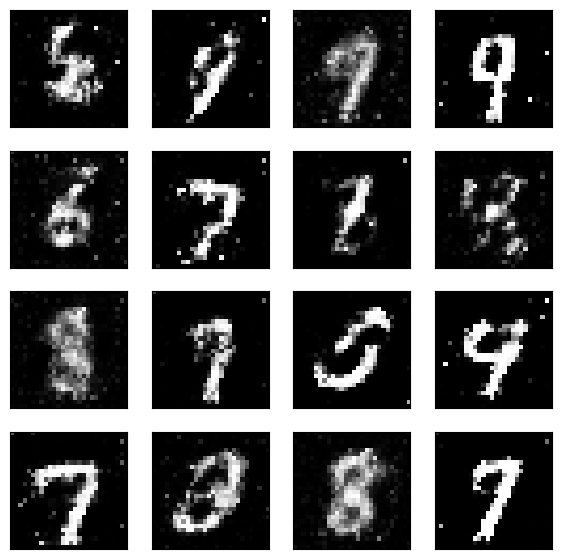

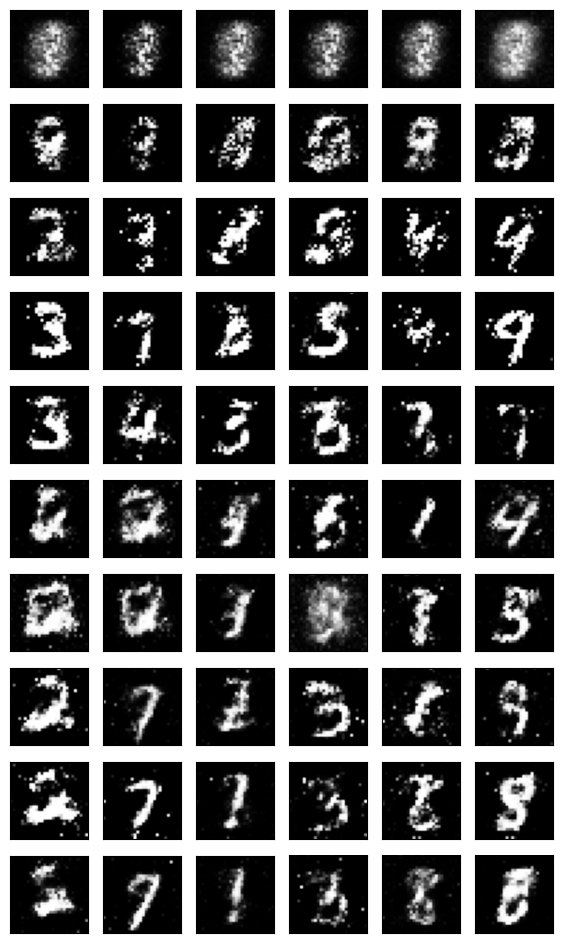

In [29]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
 fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
 for ax, img in zip(axes.flatten(), samples[epoch]):
  img = img.detach()
  ax.xaxis.set_visible(False)
  ax.yaxis.set_visible(False)
  im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')


# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
 samples = pkl.load(f)


# -1 indicates final epoch's samples (the last in the list)
view_samples(-1, samples)

rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)
for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
 for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
  img = img.detach()
  ax.imshow(img.reshape((28,28)), cmap='Greys_r')
  ax.xaxis.set_visible(False)
  ax.yaxis.set_visible(False)


Новые образцы

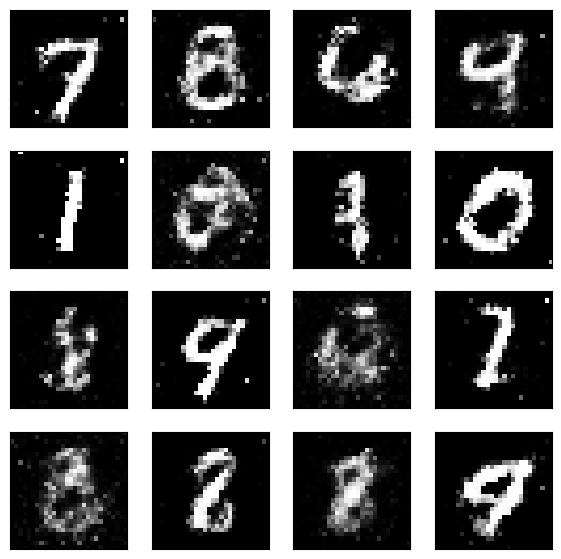

In [30]:
# randomly generated, new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()
G.eval() # eval mode
# generated samples
rand_images = G(rand_z)
# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])